In [4]:
import numpy as np
from qiskit import QuantumCircuit

# The Bernstein-Vazirani Algorithm

In [5]:
from qc.qiskit_helper import hadamard, measure, simulate

Step 1: Put the initial state in a superposition
$$
H^{\otimes n} |x>_n = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} |x>_n
$$
Step 2: Call the subroutine that pefrorms the inner product with the unknown string
$$
U_f \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} |x>_n = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{a\cdot x}|x>_n
$$
Step 3: Recover the unknown via interference
$$
H^{\otimes n} \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{a\cdot x}|x>_n = |a>_n
$$

In [16]:
def string_to_circuit(s: str):
    s = s[::-1] # reverse s to fit qiskit's qubit ordering
    n = len(s)
    oracle = QuantumCircuit(n+1)
    for q in range(n):
        if s[q] == '0':
            oracle.i(q)
        else:
            oracle.cx(q, n)
    return oracle

def bv_oracle(s: str):
    oracle = string_to_circuit(s)
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Inner Product"
    return oracle_gate

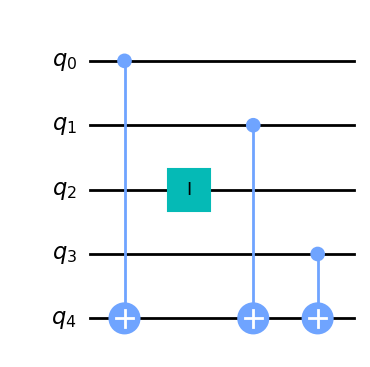

In [17]:
a = '1011'   # the hidden binary string
oracle = string_to_circuit(a)
oracle.draw(output='mpl')

In [18]:
def build_circuit(oracle, n):
    bv_circuit = QuantumCircuit(n+1, n)

    # put auxiliary in state |->
    bv_circuit.x(n)
    bv_circuit.h(n)
    
    # Apply Hadamard gates before querying the oracle
    hadamard(bv_circuit, n)

    # Apply barrier
    bv_circuit.barrier()

    #introduce the oracle gate as a subroutine
    bv_circuit.append(oracle, range(n+1))

    # Apply barrier
    bv_circuit.barrier()

    #Apply Hadamard gates after querying the oracle
    hadamard(bv_circuit, n)

    # Measurement
    measure(bv_circuit, n)
    return bv_circuit

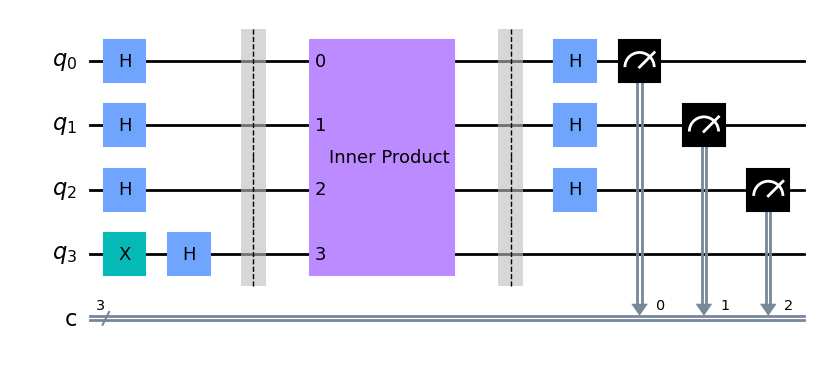

In [19]:
a = '101'   # the hidden binary string
n = len(a)
oracle = bv_oracle(a)
circuit = build_circuit(oracle, n)
circuit.draw(output='mpl')

In [20]:
answer = simulate(circuit)

In [21]:
print(answer)

{'101': 1000}


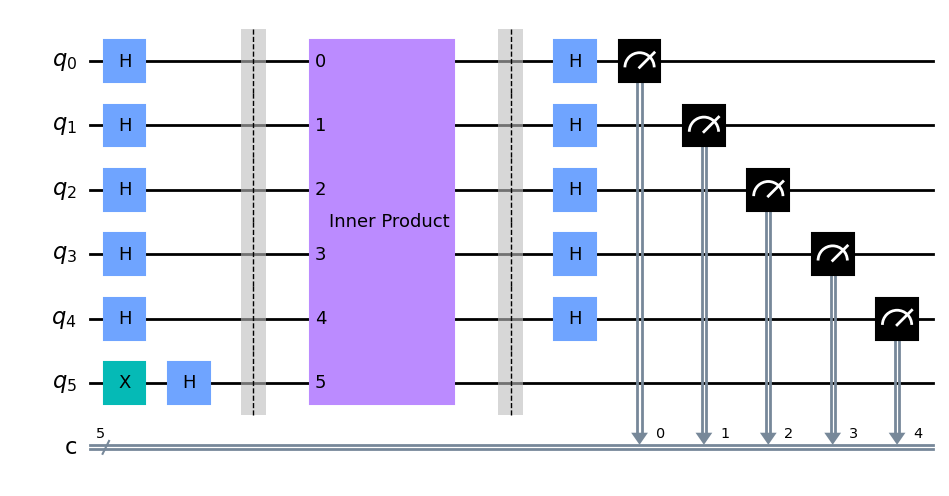

In [22]:
# Try a longer string 
a = '10100'   # the hidden binary string
n = len(a)
oracle = bv_oracle(a)
circuit = build_circuit(oracle, n)
circuit.draw(output='mpl')

In [23]:
answer = simulate(circuit)
print(answer)

{'10100': 1000}
